# Organization
Because the 2 Tasks in this homework are not so heavy, we each developed our own code, and then compared our results and improved each solution together. The source codes written by Wu and Gao are presented and compared in the report.
In this report, Gao analysed the problem of Task 1 and described our approaches to solve the problem, Wu for Task 2, and Wei gave a discussion and summarization.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from homework1.Homework_1_function_headers_group4 import guided_modes_1DTE_wu as wu_1D
from homework1.Homework_1_function_headers_group4 import guided_modes_1DTE_gao as gao_1D
from homework1.Homework_1_function_headers_group4 import guided_modes_2D_wu as wu_2D
from homework1.Homework_1_function_headers_group4 import guided_modes_2D_gao as gao_2D

In [2]:
#global parameters
lam = 0.78
k0 = 2*np.pi/lam
e_substrate = 2.25
delta_e = 1.5e-2
w = 15.0

# Task 1
Our task is to implement a finite difference mode solver. And in the 1D case we first use the discretization of the linear differential operator

$$L = \frac{1}{k}\frac{d^2}{dx^2}+\varepsilon(x)$$

which is in eigenvalue equation
$$LE(x) = \varepsilon_{eff}E(x)$$

In order to make calculation easier, we approximate the second order derivative using a finite difference scheme. We use the discretized eigenmodes of the permittivity distribution from this matrix. The source code in 1D mode solver can be found in file 'Homework_1_function_headers_group_4'.

First we approximate the second-order derivatives with a symmetric finite difference scheme, which results in a tridiagonal matrix. This matrix first defines the primary and secondary diagonal's and then will be assembled into an operator matrix using the primary and secondary diagonals. The diagonal matrix is created using `np.diag` and its offset to the main diagonal is defined. The `np.linalg.eig` function is then used to calculate the eigenvalues and eigenvectors. Then define a perfect conducting boundary where that the edges of the discrete field vector are zero. And the effective permittivity functions corresponding to the eigenvalues and eigenvectors are arranged in descending order.

We set the substrate $\varepsilon = 2.25$, $W = 15\mu m$, $\lambda = 0.78\mu m$, and we select the guided modes whose eigenvalue are larger than the substrate permittivity but smaller than the maximum of the dielectric permittivity in the x-direction. In our test, the two groups of selected eigenvalues and guided modes created by Wu's and Gao's method are equal, and the eigenvalues are shown below.

In [3]:
# Test parameters for Task 1 (length unit in µm)
grid_size = 120
number_points = 601
h = grid_size/(number_points - 1)
xx = np.linspace( -grid_size/2, grid_size/2, number_points )
prm = e_substrate + delta_e * np.exp(-(xx/w)**2)

In [4]:
#| echo: true
eff_eps_wu, guided_wu = wu_1D(prm, k0, h)
eff_eps_gao, guided_gao = gao_1D(prm, k0, h)

e_max = prm.max()
idx_wu = (eff_eps_wu < e_max) & (eff_eps_wu > e_substrate)
idx_gao = (eff_eps_gao < e_max) & (eff_eps_gao > e_substrate)
eff_eps_wu_selected = eff_eps_wu[idx_wu]
eff_eps_gao_selected = eff_eps_gao[idx_gao]

print("Are the two groups of eigenvalue equal?:",
      np.allclose(eff_eps_wu_selected, eff_eps_gao_selected))
print("The selected eigenvalues are:", "\n", eff_eps_wu_selected)
print("Are the two groups of eigen vector equal?:",
      np.allclose(guided_wu[:, idx_wu], guided_gao[:, idx_gao]))

Are the two groups of eigenvalue equal?: True
The selected eigenvalues are: 
 [2.26401269 2.26209061 2.2602771  2.2585761  2.25699259 2.25553247
 2.25420314 2.253014   2.25197792 2.25111336 2.25045026 2.25004584]
Are the two groups of eigen vector equal?: True


Amongst other things we have to pay attention to the effect that changes in grid size have on the field. This is because the decay rate of the field is exponentially related to the distance. The choice of grid size is therefore also important. Therefore, the choice of h needs to be made carefully. And our assumption of a perfect electric conductor may also be different from the real situation. Therefore, the choice of h needs to be made with care.

# Task 2

Task 2 is an extension of Task 1. In this task we need to solve the eigenvalue problem for scalar fields by a finite difference scheme.
we write the Laplace operator in individual cartsian components
$$[\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}]u(x,y)+[k0^2\varepsilon(x,y,\omega)-\beta^2(\omega)]u(x,y)=0$$

We transform it to standard notation
$$[\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}+k0^2\varepsilon(x,y,\omega)]u(x,y)=\beta^2(\omega)u(x,y)$$

The Laplace operator can be approximated by a discrete opterator:
$$\frac{\partial^2u(x,y)}{\partial x^2} \approx \frac{u(x-h,y)-2u(x,y)+u(x+h,y)}{h^2}$$
$$\frac{\partial^2u(x,y)}{\partial x^2} \approx \frac{u(x,y-h)-2u(x,y)+u(x,y+h)}{h^2}$$

Thus,  the complete eigenvalue problem in discrete notation can be summarized as
$$\frac{u_{j+1,k}+u_{j-1,k}+u_{j,k+1}+u_{j,k-1}-4u_{j,k}}{h^2}+k_{j,k}^2(\omega)u_{j,k}=\beta^2(\omega)u_{j,k}$$

To solve this eigenvalue problem, we need to at first unfold the 2D variable $u_{j,k}$ to a 1D vector. Thus, we have to unfold the corresponding 2D dielectric permittivity to 1D vector. There are two ways to unfold $u_{j,k}$, alone row and alone colum. Our group test both 2 ways, and their results are equivalent. In Wu's implementation, `np.flatten` is used to unfold prm alone row, and in Gao's implementation, `np.ravel` with parameter order=F is used to alone colum.

![Discrete Laplace operator](Laplace_operator.jpeg){width=70%}

The difficult points of this task are create the Laplace operator and solve the eigenvalue problem efficiently. To create the Laplace operator, we first need to figure out what components are in the Laplace operator. The discrete Laplace operator is shown in Fig. 1. The numbers on the blue lines are the differentiation with respect to x (as same as the tridiagonal matrix in 1D case). The numbers on the magenta line respect to $u_{j,k+1}$ and on the yellow line respect to $u_{j,k-1}$. Hence, to we assign values to magenta and yellow lines, we can set the parameter offset in `np.diag` to n and -n, where n is the number of colum if prm is unfolded alone row.

Generally, the size of operator matrix M is very huge, in this task is more than 90000 $\times$ 90000, it's almost impossible for a personal computer to solve the eigenvalue problem of it. Fortunately, the sparsity of our operator matrix is about 0.0055%, we apply the `scipy.sparse` package to creat the operator matrix and solve the eigenvalue problem, which can highly improve the computation efficiency. `sps.spdiags` and `sps.dia_array` are used in wu's and gao's implementation to create the sparse operator matrix. The `sps.linalg.eigs` function is then used to calculate the eigenvalues and eigenvectors. To reduce computation time, we just calculate the largest 10 eigenvalues and eigenvectors, which contain the most information of our operator matrix.
Finally, we reshape each eigenvector back to its original size.

In [5]:
#2D Example Parameters
grid_size = 120
number_points = 301
numb = 10
h = grid_size/(number_points - 1)
xx = np.linspace(-grid_size/2-h,grid_size/2+h,number_points+2)
yy = np.linspace(-grid_size/2,grid_size/2,number_points)
XX,YY = np.meshgrid(xx,yy)
prm = e_substrate + delta_e * np.exp(-(XX**2+YY**2)/w**2)

In [6]:
start = time.time()
eff_eps2d_wu, guided2d_wu = wu_2D(prm, k0, h, numb)
end = time.time()
time_wu = end - start

In [7]:
start = time.time()
eff_eps2d_gao, guided2d_gao = gao_2D(prm, k0, h, numb)
end = time.time()
time_gao = end - start

To test our implementation, $\varepsilon$, W, and wavelength are set to 2.25, $15\mu m$, and $0.78\mu m$. After applying `scipy.sparse` package, the computation time drastically reduce to under 3s. Two implementations gave a same result in eigenvalues calculating. The largest 10 eigenvalues are shown below. The absolute value of guided modes by Wu's and Gao's method are shown in Fig. 2 and 3. The guided modes created by the two implementations are numerically equal but have a rotation.

In [11]:
#| echo: true
print("Running time of wu's method", time_wu)
print("Running time of gao's method", time_gao)
print("Are the two groups of eigenvalue equal?:",
      np.allclose(eff_eps2d_wu, eff_eps2d_gao))
print("The largest 10 eigenvalues are:", "\n", eff_eps2d_gao.real)

Running time of wu's method 2.716899871826172
Running time of gao's method 2.2085390090942383
Are the two groups of eigenvalue equal?: True
The largest 10 eigenvalues are: 
 [2.26304305 2.26115868 2.26115868 2.2594208  2.25935066 2.25934865
 2.25776268 2.25761929 2.25776268 2.25761929]


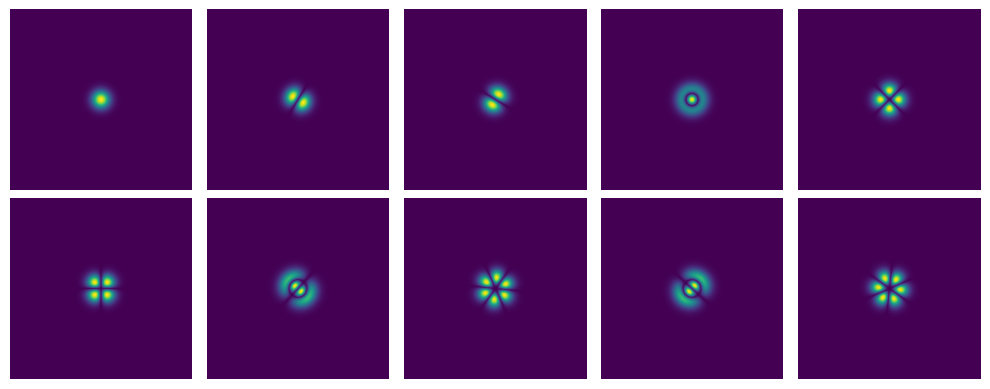

In [15]:
#| layout-ncol: 1
#| fig-cap:
#|   - "Guided modes by wu's implementation"
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in zip(range(10), axes.flatten()):
      ax.imshow(np.abs(guided2d_wu[:,:,i]))
      ax.axis('off')
plt.tight_layout()

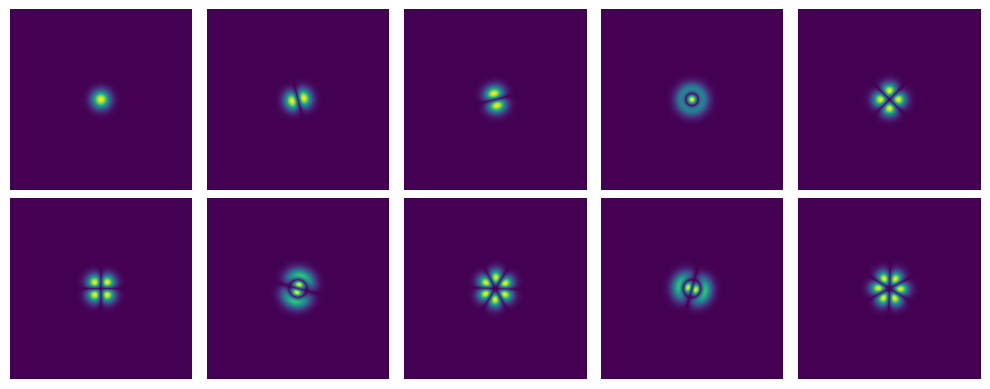

In [14]:
#| layout-ncol: 1
#| fig-cap:
#|   - "Guided modes by gao's implementation"
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in zip(range(10), axes.flatten()):
      ax.imshow(np.abs(guided2d_gao[i,:,:]))
      ax.axis('off')
plt.tight_layout()

\newpage
# Discussion